<a name="outline"></a>

## Outline

- [Task 1](#task-1): Regression
  - [1.1](#q11) Linear regression
  - [1.2](#q12) Ridge regression
  - [1.3](#q13) Relaxation of Lasso regression
- [Task 2](#task-2): Classification
  - [2.1](#q21) kNN classifier
  - [2.2](#q22) Random forest 
  - [2.3](#q23) Support vector machine (SVM) 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Logistic regression and bagging 
  - [3.2](#q32) Kernelised SVM classifier 

<a name="task-1"></a>
# Task 1: Regression [^](#outline)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a name="q11"></a>

## 1.1  [^](#outline)



To begin with, the data will be loaded from the .csv files and transformed accordingly. The first transformation is to standardise the data, ensuring consistency. The following, general, method is used:

$$
X_{std} = \frac{X - \mu}{\sigma}
$$

Where $\mu$ and $\sigma$ are the mean and standard deviation of $X$, respectively.

In [2]:
def standardise(X):
    mu = np.mean(X, 0)
    sigma = np.std(X, 0)
    X_std = (X - mu) / sigma
    return X_std

In [3]:
def read_csv(path_to_csv):
    #File extension must be .csv
    assert(path_to_csv[-4:] == ".csv")
    csv_file = pd.read_csv(path_to_csv)
    
    X = csv_file.iloc[:, :-1].to_numpy()
    y = csv_file.iloc[:, -1].to_numpy().reshape(-1, 1)

    return X, y

The next transformation is to augment the predictors matrix to allow for simpler optimisation of the intercept. Indeed, for linear regression tasks the prediction is of the form:

$$
f_{LR}(\mathbf{x}, \boldsymbol{\beta}) = \beta_0 + \beta_1 x_1 + \dots \beta_p x_p = \begin{bmatrix} 1 \\ \mathbf{x} \end{bmatrix} \cdot \begin{bmatrix}\beta_0\\ \boldsymbol{\beta_1} \end{bmatrix} 
$$

Where $\boldsymbol{\beta_1} = (\beta_1 \dots \beta_p)^T$ and $\mathbf{x} = (x_1, \dots, x_p)$. This way, by 'augmenting' $X$ such that all of its rows are preceded by a $1$, computations later down the line may be simplified.

In [4]:
def augment(X):
    rows, cols = X.shape

    return np.hstack((np.ones((rows, 1)), X))

In [5]:
chem_X_train_raw, chem_y_train = read_csv("../res/chemistry_samples.csv")

chem_X_train_std = standardise(chem_X_train_raw)
chem_X_train = augment(chem_X_train_std)


In [174]:
chem_X_test_raw, chem_y_test = read_csv("../res/chemistry_test.csv")

chem_X_test_std = standardise(chem_X_test_raw)
chem_X_test = augment(chem_X_test_std)

Choosing the mean squared error as the metric for the accuracy of the linear model, one may write its cost function as:

$$
L_{MSE}(\mathbf{y}, \mathbf{\hat{y}}) = \frac{||\mathbf{y} - \mathbf{\hat{y}}||^2}{N}
$$

Of course, for the regression model:

$$
L_{MSE}(\mathbf{y}, f_{LR}(\mathbf{x}, \boldsymbol{\beta})) = \frac{||\mathbf{y} - \mathbf{X} \boldsymbol{\beta}||^2}{N}
$$

Taking the derivative with respect to $\boldsymbol{\beta}$ gives:

$$
-\frac{2}{N}[\mathbf{X}^T \boldsymbol{y} - \mathbf{X}^T\mathbf{X} \boldsymbol{\beta}]
$$

Provides the location of an extremum at:

$$
\boldsymbol{\beta}^* = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

And the hessian:

$$
H =\frac{2}{N}\mathbf{X}^T \mathbf{X}
$$

The hessian for the mean squared error, as shown above, is positive definite. $v^T X^TX v = (Xv)^T (Xv) = ||Xv||^2 \geq 0$. Therefore, the value of $L_{MSE}$ achieved at $\beta^*$ is a minimum since $L_{MSE}$ is convex, with respect to $\boldsymbol{\beta}$.

In [175]:
def est_beta_LS(X, y):
    return np.linalg.solve(np.transpose(X) @ X, np.transpose(X) @ y)

In [176]:
def lin_pred(X, beta):
    return X @ beta

In [177]:
def r2_score(y_test, y_pred):
  numerator = np.sum((y_test - y_pred)**2)
  y_avg = np.mean(y_test)
  denominator = np.sum((y_test - y_avg)**2)
  
  return 1 - numerator/denominator

In [178]:
def mse(y_test, y_pred):
    return np.square(y_test - y_pred).mean()

In [179]:
ls_beta = est_beta_LS(chem_X_train, chem_y_train)
print("beta:\n", ls_beta)

y_pred_in = lin_pred(chem_X_train, ls_beta)
y_pred_out = lin_pred(chem_X_test, ls_beta)

print("In sample R^2:" , r2_score(chem_y_train, y_pred_in))
print("Out of sample R^2:" , r2_score(chem_y_test, y_pred_out))

beta:
 [[ 4.13993035e+00]
 [ 3.49957912e-02]
 [ 5.37535218e-01]
 [-1.50813246e-02]
 [ 2.53095451e-01]
 [ 4.38729982e-03]
 [ 5.65182177e-01]
 [-2.64033733e-01]
 [-2.53852943e-01]
 [-7.99453417e-02]
 [-8.28905840e-04]]
In sample R^2: 0.8718259975718016
Out of sample R^2: 0.8640737746110231


The above results displays clearly, and expectedly, the in sample $R^2$ score as greater than the out of sample. This is simply due to the fact that this was the data on which the linear regression was optimised for, hence better correlation. However, it is interesting, and perhaps relieving, that the correlation of the out of sample data is not too far off; this shows that the model does not overfit for the training data and in fact does a good job at predicting based on its predictors.

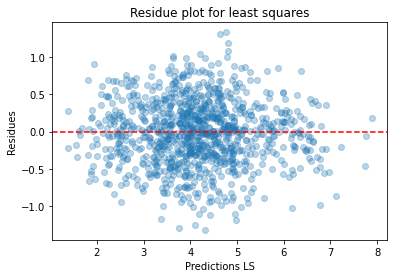

In [180]:
plt.title("Residue plot for least squares")
plt.xlabel("Predictions LS")
plt.ylabel("Residues")
plt.scatter(y_pred_out, chem_y_test - y_pred_out, alpha=0.3)
plt.axhline(y=0, linestyle="--", color="red")

<a name="q12"></a>
## 1.2 [^](#outline)

The next techinique employed is ridge regression, where the cost is altered slightly to discriminate against larger $\boldsymbol{\beta}$'s:

$$
L_{RIDGE}(\mathbf{y}, f_{LR}(\mathbf{x}, \boldsymbol{\beta})) = ||\mathbf{y} - \mathbf{X} \boldsymbol{\beta}||^2 + \lambda ||\boldsymbol{\beta}||^2
$$

Which, just as for the least squares regression, can be differentiated to produce:

$$
\nabla_{ \boldsymbol{\beta}}L_{RIDGE} = -2\mathbf{X}^T\mathbf{y} + 2(\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})\boldsymbol{\beta}
$$

Which is zero when:

$$
\boldsymbol{\beta}^* = (\mathbf{X}^T \mathbf{X} + \lambda I)^{-1} \mathbf{X}^T y
$$

Differentiating again gives the hessian of this particular cost function to be:

$$
\mathbf{X}^T \mathbf{X} + \lambda I
$$

Which is clearly positive definite, as both terms are positive definite. Once again, ensuring $\boldsymbol{\beta}^*$ is a minimum.

One stark different with this model, compared to least squares, is the additional degree of freedom $\lambda$ which also needs to be optimised such that it fits the data best.

In [181]:
def est_beta_ridge(X, y, penalty):
    rows, cols = X.shape
    
    I = np.identity(cols)
    I[0, 0] = 0

    beta_ridge = np.linalg.solve(np.transpose(X) @ X + penalty * I, np.transpose(X) @ y)
    return beta_ridge

To solve the issue of choosing an optimal $\lambda$, T-fold validation will be used on the training data. To avoid overfitting, the data within the folds will be randomly chosen (without replacement) as to ensure the model is not optimised for the ordering of the data. For this example, five folds will be used.

In [182]:
np.random.seed(1337)

folds_count = 5
chem_indicies = np.random.permutation(np.arange(len(chem_X_train)))
chem_fold_indicies = np.array_split(chem_indicies, folds_count)


In [183]:
#Accepts as input:
#folds: 2-D array of indicies representing segments of training data
#X: training data predictors
#y: training data results
#estimate_func: function which takes in training data and predictors of testing data
#and returns prediction of results for testing data
#validation_func: function which takes in actual results and predictions then returns
#a score based on accuracy of prediction 
def cross_validate(folds, X_train, y_train, estimate_func, validation_func, *est_args):
    mse_acc = 0
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]

        X_val_i = X_train[val_indexes, :] # <- SOLUTION
        y_val_i = y_train[val_indexes] # <- SOLUTION

        pred = estimate_func(X_train_i, y_train_i, X_val_i, *est_args)
        mse_acc += validation_func(pred, y_val_i)

    # Return the average score
    return mse_acc / len(folds) # <- SOLUTION

In [184]:
def scan_lambda(lambda_set, folds, X, y, estimate_func, validation_func, *est_args):
    errors = np.zeros(len(lambda_set))

    for i, lambda_var in enumerate(lambda_set):
        errors[i] = cross_validate(folds, X, y, estimate_func, validation_func, lambda_var, *est_args)

    return errors 

In [185]:
def ridge_pred(X_train, y_train, X_test, penalty):
    return lin_pred(X_test, est_beta_ridge(X_train, y_train, penalty))

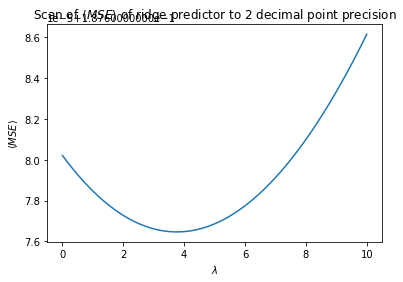

Approximation of optimal lambda: 3.7600000000000002


In [186]:
samples = 1001
init_min = 0    #first lambda to check in first pass
init_max = 10   #second lambda to check in second pass
course_lambda_set = np.linspace(init_min, init_max, samples)

#calculation of lambda interval used by 'scan_lambda'
lambda_step = (init_max - init_min) / (samples - 1)

course_errors = scan_lambda(
    course_lambda_set,
    chem_fold_indicies, 
    chem_X_train, 
    chem_y_train,
    ridge_pred,
    mse)

plt.figure()
plt.title("Scan of $\\langle MSE \\rangle$ of ridge predictor to 2 decimal point precision")
plt.xlabel("$\lambda$")
plt.ylabel("$\\langle MSE \\rangle$")
plt.plot(course_lambda_set, course_errors)
plt.show()

course_lambda = course_lambda_set[np.argmin(course_errors)]
print("Approximation of optimal lambda:", course_lambda)

The above graph gives adequate evidence of an 'optimal' $\lambda$ for this sort of problem. Indeed, the shape of the graph is convex, although this may be due to the relatively low (0.01) increment of $\lambda$. However, some analysis indicates that values of lambda too great or too small are undesirable (lead to worse predictive power), supporting the shape of the graph above. Below it will be shown that this is a problem of variance vs bias.

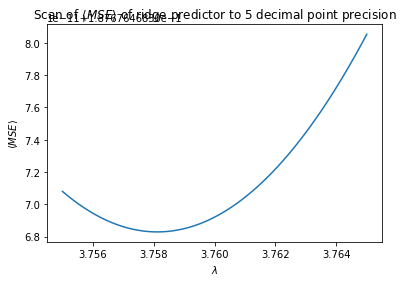

Minimum mean squared error:  0.18767646836828572
Further refinement of lambda:  3.7581200000000003


In [187]:
fine_lambda_set = np.linspace(
    course_lambda - lambda_step/2, 
    course_lambda + lambda_step/2, 
    samples)

fine_errors = scan_lambda(
    fine_lambda_set,
    chem_fold_indicies, 
    chem_X_train,
    chem_y_train,
    ridge_pred,
    mse)

plt.figure()
plt.title("Scan of $\\langle MSE \\rangle$ of ridge predictor to 5 decimal point precision")
plt.xlabel("$\lambda$")
plt.ylabel("$\\langle MSE \\rangle$")
plt.plot(fine_lambda_set, fine_errors)
plt.show()

fine_lambda = fine_lambda_set[np.argmin(fine_errors)]
print("Minimum mean squared error: ", np.min(fine_errors))
print("Further refinement of lambda: ", fine_lambda)

One may calculate the bias of the ridge regressor to be:

$$
\text{bias}(\boldsymbol{\beta}) = -\lambda (\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1} \boldsymbol{\beta}
$$

From this, it is quite clear that as $\lambda \to 0$ the least squares regression is recovered, leading to zero bias; on the other hand, in the limit to infinity, the variance tends to $-\boldsymbol{\beta}$.

Since this is vector quantity, to get a better grasp of the data as a whole, the 2-norm of this variance result will be plotted below.

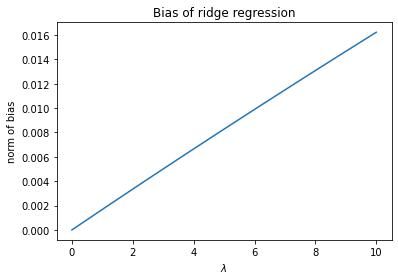

In [188]:
def ridge_bias(X, y, penalty):
    rows, cols = X.shape

    I = np.identity(cols)
    I[0, 0] = 0

    return -penalty * np.linalg.solve(X.T @ X + penalty * I, est_beta_ridge(X, y, penalty))

biases = np.zeros(len(course_lambda_set))
for i, penalty in enumerate(course_lambda_set):
    bias = ridge_bias(chem_X_train, chem_y_train, penalty)

    biases[i] = np.sqrt(bias.T @ bias)

plt.figure()
plt.title("Bias of ridge regression")
plt.xlabel("$\lambda$")
plt.ylabel("norm of bias")
plt.plot(course_lambda_set, biases)
plt.show()


The plot above affirms the analysis, showing a linear increase in the 2-norm of the bias as $\lambda$ increases. However, a quick calculation spits out the variance of this model to be:

$$
\text{var}(\boldsymbol{\beta}) = \sigma^2 \mathbf{V} \left[\text{diag}\left(\frac{d_1}{(d_1 + \lambda)^2}, \dots, \frac{d_n}{(d_n + \lambda)^2}\right) \right]\mathbf{V}^T
$$

Where $\mathbf{V}$ satisfies $\mathbf{VDV}^T = \mathbf{X}^T\mathbf{X}$ and $\mathbf{D} =$ diag($d_1, \dots, d_n$)

The above provides insight into the behavious of the variance as $\lambda \to\infty$, the sandwiched diagonal matrix's entries tend to zero and the variance follows suit. It is also quite clear to see that the variance decreases as quadratic speed. Taking the determinant of this matrix provides a scalar metric for the overall variance of the data.

$$
|\text{var}(\boldsymbol{\beta})| = \sigma^2 |\mathbf{V}|\left| \left[\text{diag}\left(\frac{d_1}{(d_1 + \lambda)^2}, \dots, \frac{d_n}{(d_n + \lambda)^2}\right) \right]\right||\mathbf{V}^T|
$$

Since $\mathbf{V}^{-1} = \mathbf{V}^T$, the above simplifies to:

$$
|\text{var}(\boldsymbol{\beta})| = \sigma^2 \prod_{i=1}^n\frac{d_i}{(d_i + \lambda)^2}
$$




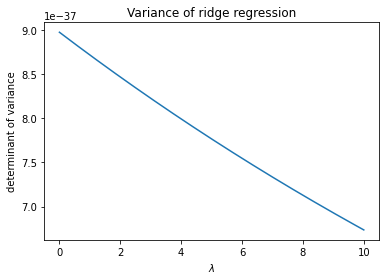

In [189]:
d, V = np.linalg.eig(chem_X_train.T @ chem_X_train)

ridge_variances = [np.prod(d/(d + penalty)**2) for penalty in course_lambda_set]

plt.figure()
plt.title("Variance of ridge regression")
plt.xlabel("$\lambda$")
plt.ylabel("determinant of variance")
plt.plot(course_lambda_set, ridge_variances)
plt.show()


As can be seen, the variance decreases as $\lambda$ increases. The game is then played to find a balance between variance and bias.

In [299]:
ridge_beta = est_beta_ridge(chem_X_train, chem_y_train, fine_lambda)
print(ridge_beta)

mag2_beta = np.sum((ridge_beta[1:])**2)
print("magnitude^2 of optimal beta1: ", mag2_beta)

print("Out of sample MSE:", mse(chem_y_test, lin_pred(chem_X_test, ridge_beta)))

print("In sample R^2:", r2_score(chem_y_train, lin_pred(chem_X_train, ridge_beta)))
print("Out of sample R^2:", r2_score(chem_y_test, lin_pred(chem_X_test, ridge_beta)))

[[ 4.13993035e+00]
 [ 3.71239257e-02]
 [ 5.35081436e-01]
 [-1.67470150e-02]
 [ 2.52731065e-01]
 [ 5.01197604e-03]
 [ 5.64526226e-01]
 [-2.62666550e-01]
 [-2.51839763e-01]
 [-7.95135185e-02]
 [ 1.41383221e-03]]
magnitude^2 of optimal beta1:  0.8093001439245369
Out of sample MSE: 0.1876669021929534
In sample R^2: 0.8718243876874945
Out of sample R^2: 0.8640843070731236


It is clear to see from the data above that the ridge estimator does a decent job, when considering the $R^2$ score. It is, however, very similar to the least squares method in terms of $R^2$ score. In fact, the scores for both out of sample and in sample differ by less than $10^{-5}$. This could be due to the fact that the least squares regression is already a good descriptor of the data.

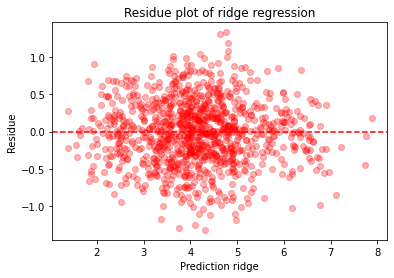

In [191]:
chem_out_pred = lin_pred(chem_X_test, ridge_beta)
plt.title("Residue plot of ridge regression")
plt.xlabel("Prediction ridge")
plt.ylabel("Residue")
plt.scatter(chem_out_pred, chem_y_test - chem_out_pred, color="red", alpha=0.3)
plt.axhline(y=0, linestyle="--", color = "red")

<a name="q13"></a>

## 1.3 [^](#outline)




For the final regression task, a lasso model will be employed with cost function:

$$
f_{LASSO}(\boldsymbol{\beta}) = ||\mathbf{y} - \mathbf{X}\boldsymbol{\beta}||^2 + \lambda \sum_{i=1}^p L_c(\beta_i)
$$

Where:

$$
L_c(\beta) = \begin{cases}\frac{\beta^2}{2} & |\beta| \leq c \\ c (|\beta| - \frac{c}{2}) & \text{otherwise}\end{cases}
$$

Differentiating the above with respect to $\boldsymbol{\beta}$ gives:

$$
\nabla_{\boldsymbol{\beta}}f_{LASSO} = \frac{-2}{N}[\mathbf{X}^T y - X^T X \boldsymbol{\beta}] + \lambda \begin{bmatrix}L'_c(\beta_1) \\ \vdots \\ L'_c(\beta_p) \end{bmatrix}
$$

Where:

$$
L'_c(\beta) = \begin{cases} \beta & |\beta| \leq c \\ c \cdot\text{sign}{\beta} & \text{otherwise}\end{cases}
$$

In [192]:
import numpy as np

In [193]:
def huber(beta, c=1e-6):
    result = np.where(
        np.abs(beta) <= c,        #if
        (beta ** 2) / 2,          #then
        c * (np.abs(beta) - c/2)) #else
    result[0, 0] = 0
    
    return result
  
def grad_huber(beta, c=1e-6):
    result = np.where(
        np.abs(beta) <= c, #if
        beta,              #then
        c * np.sign(beta)) #else
    result[0, 0] = 0

    return result

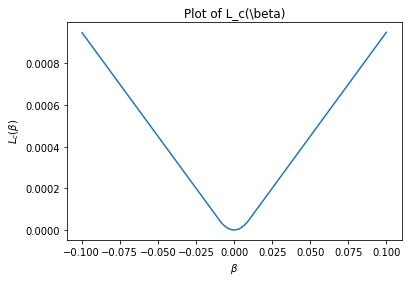

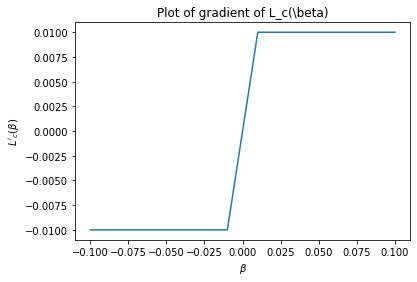

In [194]:
beta = np.linspace(-0.1, 0.1, 1000).reshape(1, -1)

plt.figure()
plt.title("Plot of L_c(\\beta)")
plt.xlabel("$\\beta$")
plt.ylabel("$L_c(\\beta)$")
plt.plot(beta[0][1:], huber(beta, 0.01)[0, 1:])
plt.show()

plt.figure()
plt.title("Plot of gradient of L_c(\\beta)")
plt.xlabel("$\\beta$")
plt.ylabel("$L'_c(\\beta)$")
plt.plot(beta[0][1:], grad_huber(beta, 0.01)[0, 1:])
plt.show()

plt.show()

In [195]:
def lasso_cost(X, y, beta, penalty, c = 0.001):
    return np.square(y - lin_pred(X, beta)).mean() + penalty * np.sum(huber(beta[1:], c))


The method employed for optimising $\boldsymbol{\beta}$ will be a gradient descent, in mathematical terms:

$$
\boldsymbol{\beta}_{n+1} = \boldsymbol{\beta}_n - \eta \nabla_{\boldsymbol{\beta}}f_{LASSO}(\boldsymbol{\beta}_n)
$$

Where $\eta$ is some small constant. 

In [196]:
def minimize_ls_huber(X, y, lambd, n_iters=10000, step_size=1e-3):
    n, p = X.shape
    XX = X.T @ X / n
    Xy = X.T @ y / n
    
    # next line: initialise betas
    beta = np.zeros(shape = (p, 1))

    # gradient descent (hint: see logistic regression coding task)
    for _ in range(n_iters):     
        grad = 2 * (XX @ beta - Xy) + lambd * grad_huber(beta, 0.001)
        # next line: gradient descent update
        beta = beta - grad * step_size
      
    return beta

In [197]:
def lasso_pred(X_train, y_train, X_test, penalty):
    return lin_pred(X_test, minimize_ls_huber(X_train, y_train, penalty))

In [198]:
lasso_lambda_set = np.linspace(0, 5, 501)
laso_errors = scan_lambda(
    lasso_lambda_set,
    chem_fold_indicies,
    chem_X_train,
    chem_y_train,
    lasso_pred,
    mse)

Optimal lambda: 0.12


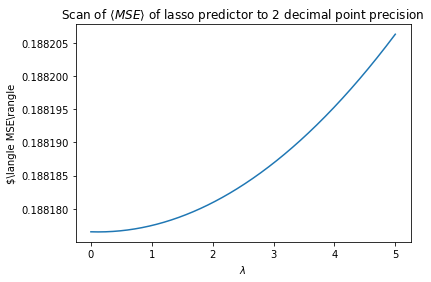

In [199]:
best_lambda = lasso_lambda_set[np.argmin(laso_errors)]
print("Optimal lambda:", best_lambda)

plt.figure()
plt.title("Scan of $\\langle MSE \\rangle$ of lasso predictor to 2 decimal point precision")
plt.xlabel("$\\lambda$")
plt.ylabel("$\\langle MSE\\rangle")
plt.plot(lasso_lambda_set, laso_errors)
plt.show()

As can be seen above, the value of $\lambda$ appears to find a minimum (perhaps local) at $\lambda=0.12$. From here, assuming that locally the function is convex a more precise value can be acquired by reducing the search spread and also decreasing the step. This is a comprise to reduce computational cost.

In [200]:
finer_lasso_lambda_set = np.linspace(
    best_lambda - 0.01/2, 
    best_lambda + 0.01/2, 
    101)

finer_lasso_errors = scan_lambda(
    finer_lasso_lambda_set, 
    chem_fold_indicies,
    chem_X_train,
    chem_y_train,
    lasso_pred,
    mse)

Optimal lambda: 0.1201


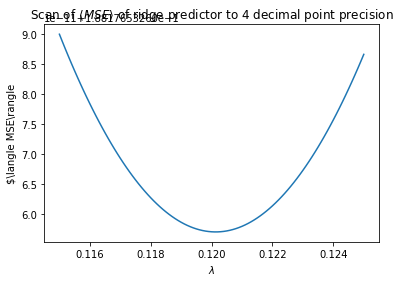

In [201]:
lasso_lambda = finer_lasso_lambda_set[np.argmin(finer_lasso_errors)]
print("Optimal lambda:", lasso_lambda)

plt.figure()
plt.title("Scan of $\\langle MSE \\rangle$ of ridge predictor to 4 decimal point precision")
plt.xlabel("$\\lambda$")
plt.ylabel("$\\langle MSE\\rangle")
plt.plot(finer_lasso_lambda_set, finer_lasso_errors)
plt.show()

In [202]:
def minimize_ls_huber_with_costs(X, y, lambd, n_iters=10000, step_size=1e-3):
    n, p = X.shape
    XX = X.T @ X / n
    Xy = X.T @ y / n
    
    # next line: initialise betas
    beta = np.zeros(shape = (p, 1))
    costs = []

    # gradient descent (hint: see logistic regression coding task)
    for i in range(n_iters):
        grad = 2 * (XX @ beta - Xy) + lambd * grad_huber(beta, 0.001)
        # next line: gradient descent update
        beta = beta - grad * step_size

        costs.append(lasso_cost(X, y, beta, lambd))
      
    return beta, costs

lasso optimal beta:
 [[ 4.13993034]
 [ 0.07645867]
 [ 0.50279028]
 [-0.04357328]
 [ 0.25091312]
 [ 0.01484006]
 [ 0.5645058 ]
 [-0.23712774]
 [-0.21146512]
 [-0.07147818]
 [ 0.03310898]]
Difference of magnitude of ridge beta and lasso beta:  [[-0.00705889]]
In sample MSE: 18.4044038276171
Out of sample MSE: 0.18791119586694946
In sample R^2 score: 0.8714465693678559
Out of sample R^2 score 0.863907380062602


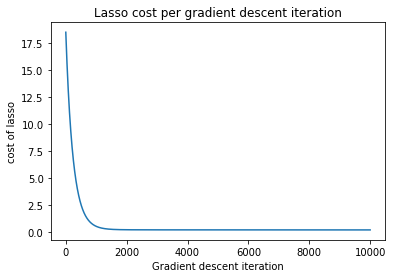

In [298]:
opt_beta, costs = minimize_ls_huber_with_costs(chem_X_train, chem_y_train, best_lambda)
pred_train = lin_pred(chem_X_train, opt_beta)
pred_test = lin_pred(chem_X_test , opt_beta)

print("lasso optimal beta:\n", opt_beta)
print("Difference of magnitude of ridge beta and lasso beta: ", np.sqrt((opt_beta).T @ (opt_beta)) - np.sqrt((ridge_beta).T @ (ridge_beta)))

print("In sample MSE:"    , mse(chem_X_train, pred_train))
print("Out of sample MSE:", mse(chem_y_test, pred_test))

print("In sample R^2 score:",    r2_score(chem_y_train, pred_train))
print("Out of sample R^2 score", r2_score(chem_y_test , pred_test))

plt.figure()
plt.title("Lasso cost per gradient descent iteration")
plt.xlabel("Gradient descent iteration")
plt.ylabel("cost of lasso")
plt.plot(costs)
plt.show()

Singleing out the optimal lambda calculated previously and performing a gradient descent using this value, a depiction of what the gradient descent does is shown above. With every step, the Lasso cost of the function is reduced until it can be no more.

The calculated MSE for the in sample data is significantly lower for lasso than it is for ridge, this is perhaps a consequence of the differing magnitudes of lambda. From the above statistics, it is clear to see that the difference between the optimal $\boldsymbol{\beta}$ for ridge and lasso is very small and thus plays little part in this conundrum. Hence, Lasso with a smaller penalty is a better approximation to the least squares model, which is designed to minimise MSE. This is because the addition cost terms are smaller than the ridge regression with larger penalty, explaining why (for this data), lasso performs better under the MSE metric. Otherwise, its $R^2$ scores are essentially identical.

However, the same can not be said about the out of sample mean squared errors which are more equal across ridge and lasso, with a great disparity between the in sample and out of sample MSE for lasso. This perhaps shows some semblance of overfitting.

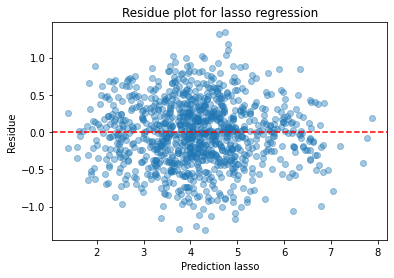

In [204]:
plt.title("Residue plot for lasso regression")
plt.xlabel("Prediction lasso")
plt.ylabel("Residue")
plt.scatter(pred_test, chem_y_test - pred_test, alpha=0.4)
plt.axhline(y=0, linestyle="--", color = "red")

<a name="task-2"></a>

# Task 2: Classification [^](#outline)

<a name="q21"></a>

## 2.1 [^](#outline)

In [205]:
def tumor_string_to_int_map(y):
    return np.where(y == 'B', 1, 0).ravel()

As before, standardise the data, but this time, tumour_samples.csv (and in fact all tumour related files) have an extra column which is not need. This is to be removed from the data set here. Moreover, it is more useful to have the two classifications "M" and "B" as the numbers 1, and 0 signifying postive and negative.

In [206]:
tumour_X_train_raw, tumour_y_train = read_csv("../res/tumour_samples.csv")
tumour_X_train = standardise(tumour_X_train_raw[:, 1:])

tumour_y_train = tumor_string_to_int_map(tumour_y_train).ravel()


In [207]:
tumour_X_test_raw, tumour_y_test = read_csv("../res/tumour_test.csv")
tumour_X_test = standardise(tumour_X_test_raw[:, 1:])

tumour_y_test = tumor_string_to_int_map(tumour_y_test).ravel()


In [208]:
def distance(x, y):
    return np.sqrt(np.sum(np.square(x - y), axis=1))

Next, the neighbourhood of a point will be defined as the $k$ nearest points (in this case distance is given by the euclidean metric) to the point. The calculation is done by simple brute force:

In [209]:
def k_neighbours(X_train, X_test, k):
    distances = [distance(x_test, X_train) for x_test in X_test]

    result = np.zeros((len(X_test), k), dtype=int)

    for i, train_i_dists in enumerate(distances):
        neighbour_dists = enumerate(train_i_dists)
        nearest_neighbours = sorted(neighbour_dists, key = lambda x: x[1])[:k]

        result[i] = [neighbour[0] for neighbour in nearest_neighbours]

    return result



The knn will predict a given value to be the modal class within its neighbourhood.

In [210]:
def knn_predict(X_train, y_train, X_test, k):
    neighbours = k_neighbours(X_train, X_test, k)
    
    return [np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours]

In [211]:
folds_count = 5
tumour_indicies = np.random.permutation(np.arange(len(tumour_X_train)))
tumour_fold_indicies = np.array_split(tumour_indicies, folds_count)

To be able to properly train the network, a metric for its success is necessary. In this case, this will simply be the proportion of total results it guessed correctly.

In [212]:
def knn_score(y_test, y_pred):
    return np.mean(y_test == y_pred)

In [213]:
k_set = np.arange(1, 101, dtype=int)
score_set = scan_lambda(
    k_set,
    tumour_fold_indicies, 
    tumour_X_train, 
    tumour_y_train,
    knn_predict,
    knn_score)

best k:  2


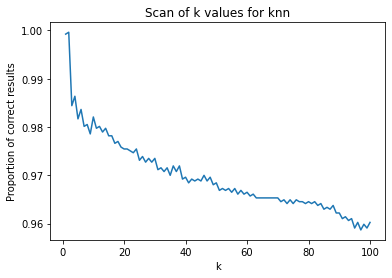

In [214]:
best_k = k_set[np.argmax(score_set)]
print("best k: ", best_k)

plt.figure()
plt.title("Scan of k values for knn")
plt.ylabel("Proportion of correct results")
plt.xlabel("k")
plt.plot(k_set, score_set)
plt.show()

In [215]:
print("In sample score: ", np.max(score_set))

out_prediction = knn_predict(tumour_X_train, tumour_y_train, tumour_X_test, best_k)
print("Out of sample score: ", knn_score(tumour_y_test, out_prediction))

In sample score:  0.9996108949416342
Out of sample score:  0.985


Here it can be clearly seen that the knn performs marvelously for both the in-sample data and the out of sample data. Once again, within expectation, the in sample score is higher than the out of sample score since the network was trained to optimise for the aptly named 'training_set'. However, the classification accuracy of the out of sample data is still very significant with only 1 in 67 predictions being wrong.

Looking at the scan of $k$ values, the trend is clearly that a greater number of neighbours decreases the accuracy of the classification. This suggests significant correlation between the data an its nearest neighbour.

<a name="q22"></a>

## 2.2 [^](#outline)


For the following classification task, a random forest with cross_entropy const will be employed. Cross entropy cost is given by:

$$
\text{CE}[\pi(R_\alpha)] = -\sum_{q=i}^Q \pi_q(R_\alpha) \log \pi_q(R_\alpha)
$$


In [216]:
def cross_entropy(y, classes_count = 2):
    """
    Calculates the GINI index
    Arguments:
        y: (np.array) vector of training labels, of shape (N,).
        classes_count: number of distinct classes (in this case 2).
    Returns:
        (int): the GINI index
    """

    class_weights = np.zeros(classes_count)

    for y_i in y:
        class_weights[y_i] += 1/len(y)
    
    #Prevents error with np.log(0)!
    if np.min(class_weights) == 0:
        return np.inf

    return -np.sum(class_weights * np.log(class_weights))

In [217]:
def split_samples(X, y, column, value):
    """
    Seperates training data column into two regions denoted by the inequality: left =>
    X < value, right => X >= value.
    Arguments:
        X: (np.array) training features, of shape (N, D).
        y: (np.array) vector of training labels, of shape (N,).
        column: (int) index of predictor to be divided.
        value: (int) delimiter.
    Returns:
        (tuple, tuple): X split followed by y split.
    """
    l_mask = X[:, column] < value
    l_mask_inv = ~l_mask

    #      left split      right split
    return (X[l_mask, :], X[l_mask_inv, :]),\
           (y[l_mask]   , y[l_mask_inv])


In [218]:
def majority_vote(y, classes_count = 2):
    """
    Calculates the modal classification.
    Arguments:
        y: vector of training labels, of shape (N,).
        classes_count: number of distinct classes (in this case 2)
    Returns:
        (int): the modal classification
    """

    if(classes_count <= 1):
        return y[0]
    else:
        class_counts = np.zeros(classes_count)

        for y_i in y:
            class_counts[y_i] += 1

        return np.argmax(class_counts)

In [219]:
# EDIT THIS FUNCTION
def ce_split_value(X, y, column):
  """
  Calculate the GINI-index based on `column` with the split that minimizes the GINI-index.
  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
  Returns:
      (float, float): the resulted GINI-index and the corresponding value used in splitting.
  """
  
  unique_vals = np.unique(X[:, column])

  assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

  ce_val = np.inf 
  threshold = None
  
  # split the values of i-th feature and calculate the cost 
  for value in unique_vals:
    (X_l, X_r), (y_l, y_r) = split_samples(X, y, column, value)

    # if one of the two sides is empty, skip this split.
    if len(y_l) > 0 and len(y_r) > 0:

      p_left = len(y_l)/(len(y_l) + len(y_r))
      p_right = 1 - p_left
      new_cost = p_left * cross_entropy(y_l) + p_right * cross_entropy(y_r)

      if new_cost < ce_val:
        ce_val = new_cost
        threshold = value
    
  return ce_val, threshold

In [220]:
## EDIT THIS FUNCTION
def ce_split_rf(n_features, X, y):
  """
  Choose the best feature to split according to criterion.
  Args:
      n_features: number of sampled features.
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
  Returns:
      (float, int, float): the minimized gini-index, the best feature index and value used in splitting.
  """
  rows, cols = X.shape

  columns = np.random.choice(np.arange(0, cols), n_features, replace=False)

  min_ce = np.inf
  split_column = None
  split_val = 0

  for column in columns:
    # skip column if samples are not seperable by that column.
    if len(np.unique(X[:, column])) > 1:
      # search for the best splitting value for the given column.
      ce, val = ce_split_value(X, y, column)
           
      if ce < min_ce:
          min_ce = ce
          split_column = column
          split_val = val

  return min_ce, split_column, split_val

In [221]:
def build_random_forest(n_features, X, y, depth, max_depth, min_samples_leaf=2):
    classes_count = len(np.unique(y))

    if(classes_count == 1 or depth >= max_depth or len(X) <= min_samples_leaf):
        return {'majority_label': majority_vote(y, classes_count)}
    else:
        ce, split_index, split_val = ce_split_rf(n_features, X, y)
        
        # If GI is infinity, it means that samples are not seperable by the sampled features.
        if ce == np.inf:
            return {'majority_label': majority_vote(y, classes_count)}
            
        (X_l, X_r), (y_l, y_r) = split_samples(X, y, split_index, split_val)
        
        return {
            'feature_index': split_index,
            'value': split_val,
            'majority_label': None,
            'left':  build_random_forest(n_features, X_l, y_l, depth + 1, max_depth, min_samples_leaf),
            'right': build_random_forest(n_features, X_r, y_r, depth + 1, max_depth, min_samples_leaf)
        }

In [222]:
def train_rf(B, n_features, X, y, max_depth):
  """
  Build the decision tree according to the training data.
  Args:
      B: number of decision trees.
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (np.array) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      max_depth: (int) maximum depth
  """
  N = X.shape[0]

  training_indices = np.arange(N)
  trees = []

  for i in range(B):
    print("Current B val: ", i)

    sample = np.random.choice(training_indices, N, replace=True)
    X_sample = X[sample, :]
    y_sample = y[sample]
    
    tree = build_random_forest(n_features, X_sample, y_sample, 1, max_depth)
    trees.append(tree)

  return trees

In [223]:
def classify(tree, x):
  """
  Classify a single sample with the fitted decision tree.
  Args:
      x: ((np.array) a single sample features, of shape (D,).
  Returns:
      (int): predicted testing sample label.
  """
  if tree['majority_label'] is not None: 
    return tree['majority_label']
  else:
    if x[tree['feature_index']] < tree['value']:
      return classify(tree['left'], x)
    else:
      return classify(tree['right'], x)

In [224]:
def predict_rf(rf, X, classes_count = 2):
  """
  Predict classification results for X.
  Args:
      rf: A trained random forest through train_rf function.
      X: (np.array) testing sample features, of shape (N, D).
  Returns:
      (np.array): predicted testing sample labels, of shape (N,).
  """

  def aggregate(decisions):
    counts = np.zeros(classes_count)
    for decision in decisions:
        counts[decision] += 1

    return np.argmax(counts)

  if len(X.shape) == 1:
      return aggregate([classify(tree, X) for tree in rf])
  else:
      return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

In [225]:
def random_forest_prediction_val(X_train, y_train, X_test, B_D_pair):
    n_features = int(np.sqrt(X_train.shape[1])) #Empirical recommendation

    B = B_D_pair[0]
    max_depth = B_D_pair[1]

    print("BD_pair: (", B, max_depth, ")")

    rf = train_rf(B, n_features, X_train, y_train, max_depth)
    return predict_rf(rf, X_test)


In [227]:
min_depth_range = 1
max_depth_range = 5

min_B_range = 1
max_B_range = 5

lambda_set = []

for B in range(min_B_range, max_B_range + 1):
    for depth in range(min_depth_range, max_depth_range + 1):
        lambda_set.append([B, depth])

rf_scores = scan_lambda(
    lambda_set, 
    tumour_fold_indicies, 
    tumour_X_train, 
    tumour_y_train, 
    random_forest_prediction_val,
    knn_score)


BD_pair: ( 1 1 )
Current B val:  0
BD_pair: ( 1 1 )
Current B val:  0
BD_pair: ( 1 1 )
Current B val:  0
BD_pair: ( 1 1 )
Current B val:  0
BD_pair: ( 1 1 )
Current B val:  0
BD_pair: ( 1 2 )
Current B val:  0
BD_pair: ( 1 2 )
Current B val:  0
BD_pair: ( 1 2 )
Current B val:  0
BD_pair: ( 1 2 )
Current B val:  0
BD_pair: ( 1 2 )
Current B val:  0
BD_pair: ( 1 3 )
Current B val:  0
BD_pair: ( 1 3 )
Current B val:  0
BD_pair: ( 1 3 )
Current B val:  0
BD_pair: ( 1 3 )
Current B val:  0
BD_pair: ( 1 3 )
Current B val:  0
BD_pair: ( 1 4 )
Current B val:  0
BD_pair: ( 1 4 )
Current B val:  0
BD_pair: ( 1 4 )
Current B val:  0
BD_pair: ( 1 4 )
Current B val:  0
BD_pair: ( 1 4 )
Current B val:  0
BD_pair: ( 1 5 )
Current B val:  0
BD_pair: ( 1 5 )
Current B val:  0
BD_pair: ( 1 5 )
Current B val:  0
BD_pair: ( 1 5 )
Current B val:  0
BD_pair: ( 1 5 )
Current B val:  0
BD_pair: ( 2 1 )
Current B val:  0
Current B val:  1
BD_pair: ( 2 1 )
Current B val:  0
Current B val:  1
BD_pair: ( 2 1 )
Cu

Optimal pair (B, max_depth): [5, 5]


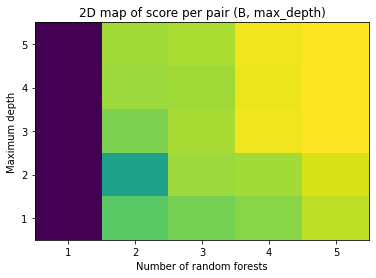

In [233]:
print("Optimal pair (B, max_depth):", lambda_set[np.argmax(rf_scores)])

X, Y = np.meshgrid(np.arange(min_B_range, max_B_range+1), np.arange(min_depth_range, max_depth_range + 1))
plt.title("2D map of score per pair (B, max_depth)")
plt.xlabel("Number of random forests")
plt.ylabel("Maximum depth")
plt.pcolormesh(X, Y, rf_scores.reshape(max_B_range - min_B_range + 1, max_depth_range - min_depth_range + 1))
plt.show()



As can be seen from the above plot, the optimal hyper-parameters seem to be (5, 5). This is of course only true for this small sample size and perhaps a greater sample would reveal different results. However, the general trend is clear that greater depth and more trees provides greater predictive potential. One thing of interest is the slight skew in importance of depth over number of trees, it is of my opinion that there is a greater improvement upon increasing the number of trees as opposed to the depth.

In [304]:
def confusion_matrix(y_actual, y_pred, map):
    matrix = np.zeros((2, 2)).astype(int)

    for y_i_actual, y_i_pred in zip(y_actual, y_pred):
        matrix[map[y_i_actual], map[y_i_pred]] += 1

    return matrix

def accuracy(conf_matrix):
    return (conf_matrix[1, 1] + conf_matrix[0, 0])/np.sum(conf_matrix)

def recall(conf_matrix):
    return conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

def precision(conf_matrix):
    return conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

def F_score(conf_matrix):
    return 2 * precision(conf_matrix) * recall(conf_matrix) / (precision(conf_matrix) + recall(conf_matrix))

In [250]:

optimal_random_forest = train_rf(5, int(np.sqrt(tumour_X_train.shape[1])), tumour_X_train, tumour_y_train, 5)

Current B val:  0
Current B val:  1
Current B val:  2
Current B val:  3
Current B val:  4


In [305]:
prediction_in  = predict_rf(optimal_random_forest, tumour_X_train)
prediction_out = predict_rf(optimal_random_forest, tumour_X_test)

map = {0:0, 1:1}
data_frame_meta = {"index":["pred M", "pred B"], "columns":["actual M", "actual B"]}

cf_in = confusion_matrix(tumour_y_train, prediction_in, map)
cf_out  = confusion_matrix(tumour_y_test, prediction_out, map)

print("Confusion matrix for in sample data:")
print(pd.DataFrame(data=cf_in, **data_frame_meta))
print()
print("accuracy: ", accuracy(cf_in)) 
print("recall: ", recall(cf_in)) 
print("F-score: ", F_score(cf_in)) 
print()
print("Confusion matrix for out of sample data:")
print(pd.DataFrame(data=cf_out,**data_frame_meta))
print()
print("accuracy: ", accuracy(cf_out)) 
print("recall: ", recall(cf_out)) 
print("F-score: ", F_score(cf_out)) 


Confusion matrix for in sample data:
        actual M  actual B
pred M       371        53
pred B         2      2140

accuracy:  0.9785658612626656
recall:  0.9758321933424533
F-score:  0.9873125720876587

Confusion matrix for out of sample data:
        actual M  actual B
pred M        49        24
pred B         0       127

accuracy:  0.88
recall:  0.8410596026490066
F-score:  0.9136690647482013


Calculating the confusion matrix for both in sample and out of sample data, provides some insight into the effectiveness of this forest. As can be seen, the tree shows stellar results for its in sample testing and great results for the out of sample. It is to be said, however, that with the current arrangement of hyperparameters the model in terms of accuracy predicts worse than the knn. It was clear from the results of the knn that this data is highly clustered (i.e. classes tend to be close to each other), with the tree being less capabable here. It is clear from the confusion matrix that this tree performs particularly well in classifying malignant data. This is reflected in that, out of 2142 malignant data points, only two were incorrectly classified (In the in sample scoring) and even better for the out of sample predictions with no wrong predictions on malignant data. However, perhaps this is an issue of sample size. Assuming the proportian of mislabeled malignant data points in the in sample data to be indicative of its actual accuracy in this category, the expectation for the more than ten times smaller out of sample data to mislabel a malignant data point is zero.

On the other hand, it is quite clear that this model struggles with classifying benign points, with the out of sample test failing to classify one in three benign points. This proportion drops to one in seven for the in sample test however. This is exactly what is needed of the example.

<a name="q23"></a>

## 2.3 [^](#outline)

In [279]:
svm_X_train = np.hstack((tumour_X_train, np.ones((tumour_X_train.shape[0], 1))))
svm_X_test  = np.hstack((tumour_X_test,  np.ones((tumour_X_test.shape[0], 1))))

#if (1) i.e. malignant then transforms to (2 - 1 = 1) otherwise transforms to 
svm_y_train = (2 * tumour_y_train - 1).astype(float)
svm_y_test  = (2 * tumour_y_test - 1).astype(float)

In [280]:
def compute_cost(w, X, y, regul_strength=1e5):
    n = X.shape[0]
    distances = 1 - y * (X @ w)  
    distances[distances < 0] = 0  
    hinge = regul_strength * distances.mean() 

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge

In [281]:
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e5):
    # if only one example is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  
        
    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = w
        else:
            di = w - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw/len(y_batch)  # average

In [282]:
def sgd(X, y, batch_size=16, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e5, print_outcome=False):
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        X_b, y_b = X[batch_idx], y[batch_idx]
        for xi, yi in zip(X_b, y_b):
            ascent = calculate_cost_gradient(weights, xi, yi, regul_strength) ## <-- SOLUTION
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost(weights, X, y, regul_strength)  ## <-- SOLUTION
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

In [283]:
def svm_pred(X_train, y_train, X_test, hardness):
    w = sgd(X_train, y_train, regul_strength=hardness)

    return np.sign(lin_pred(X_test, w))

In [284]:
hardness_set = np.linspace(0, 100, 301)[1:]
svm_error = scan_lambda(
    hardness_set,
    tumour_fold_indicies,
    svm_X_train,
    svm_y_train,
    svm_pred,
    knn_score)

Optimal svm hardness:  97.66666666666666


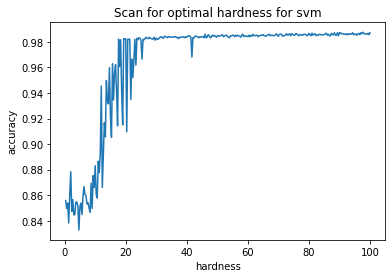

In [285]:
print("Optimal svm hardness: ", hardness_set[np.argmax(svm_error)])

plt.figure()
plt.title("Scan for optimal hardness for svm")
plt.xlabel("hardness")
plt.ylabel("accuracy")
plt.plot(hardness_set, svm_error)
plt.show()

Clearly, the above graph shows the consequences of low hardness value, which reduces the accuracy of the predictor. However, choosing a greater a greater hardness may increase the computational cost of algorithm and may be slow to compute. The general trend for this graph (and in fact all graphs) is that a greater hardness value implies a greater accuracy. 

In [286]:
from functools import cmp_to_key

In [287]:
def roc_svm(hardness_set, X_train, y_train, X_test, y_test):
    svm_tpr = np.zeros(len(hardness_set) + 2)
    svm_fpr = np.zeros(len(hardness_set) + 2)

    svm_tpr[-1] = svm_fpr[-1] = 1

    for i , hardness in enumerate(hardness_set):
        prediction = svm_pred(X_train, y_train, X_test,hardness)

        conf_matrix = np.zeros((2, 2))
        for pred_i, actual_i in zip(prediction, y_test):
            conf_matrix[int(pred_i + 1)//2, int(actual_i + 1)//2] += 1

        svm_tpr[i+1] = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
        svm_fpr[i+1] = 1 - conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])

    def comp(lhs, rhs):
        if lhs[0] > rhs[0]:
            return 1
        elif lhs[0] < rhs[0]:
            return -1
        else:
            if lhs[1] > rhs[1]:
                return 1
            elif lhs[1] < rhs[1]:
                return -1
            else:
                return 0

    sorted_fpr_trp = sorted(zip(svm_fpr, svm_tpr), key=cmp_to_key(comp))
    
    return list(zip(*sorted_fpr_trp))

AUC: 0.9784812857296947


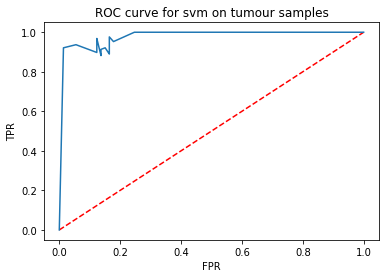

In [288]:


hardness_set_roc = np.linspace(0, 100, 101)
fpr, tpr = roc_svm(hardness_set_roc, svm_X_train, svm_y_train, svm_X_test, svm_y_test)

print("AUC:", np.trapz(tpr, x=fpr))
plt.title("ROC curve for svm on tumour samples")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.plot(fpr, tpr)

In [310]:
tumour_bal_X_train_raw, tumour_bal_y_train = read_csv("../res/tumour_samples.csv")

tumour_bal_X_train = standardise(tumour_bal_X_train_raw[:, 1:])
tumour_bal_X_train = np.hstack((tumour_bal_X_train,  np.ones((tumour_bal_X_train.shape[0], 1))))

tumour_bal_y_train = np.where(tumour_bal_y_train == "B", 1, -1).ravel().astype(float)

In [311]:
tumour_bal_indicies = np.random.permutation(np.arange(len(tumour_bal_X_train)))
tumour_bal_fold_indicies = np.array_split(tumour_bal_indicies, 5)

In [312]:
svm_bal_error = scan_lambda(
    hardness_set,
    tumour_bal_fold_indicies,
    tumour_bal_X_train,
    tumour_bal_y_train,
    svm_pred,
    knn_score)


Optimal svm hardness:  93.0


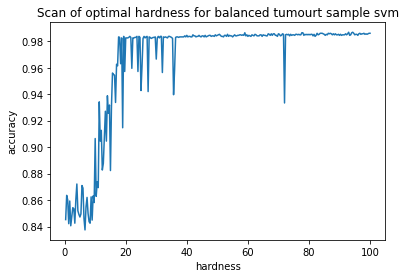

In [313]:
print("Optimal svm hardness: ", hardness_set[np.argmax(svm_bal_error)])

plt.figure()
plt.title("Scan of optimal hardness for balanced tumourt sample svm")
plt.xlabel("hardness")
plt.ylabel("accuracy")
plt.plot(hardness_set, svm_bal_error)
plt.show()

AUC: 0.9742746197821163


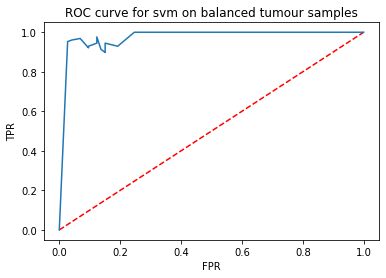

In [314]:
fpr_bal, tpr_bal = roc_svm(hardness_set_roc, tumour_bal_X_train, tumour_bal_y_train, svm_X_test, svm_y_test)

print("AUC:", np.trapz(tpr_bal, x=fpr_bal))
plt.title("ROC curve for svm on balanced tumour samples")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.plot(fpr_bal, tpr_bal)

The ROC curves reflect a good classification exactly where one would want it to be. The balanced data does show a slighly better curve overall, with more values pushed towards the upper-left corner.

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 [^](#outline)

<a name="q32"></a>

## 3.2 [^](#outline)